In [1]:
import warnings

import torch

from molbo.acquisition import *
from molbo.bo import BOLoop
from molbo.models import GPModel
from molbo.utils import init_problem, plot_1d_interactive

warnings.filterwarnings("ignore")

/home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from ipywidgets import Button, HBox, IntSlider, VBox, interactive

from molbo.bo import BOMetrics
from molbo.utils import plot_1d_iteration

sns.set_style("whitegrid")
sns.set_palette("muted")

def plot_1d_comparison_interactive(bo_loop_argmax, bo_loop_sample):
    """Interactive side-by-side comparison of argmax vs sampling BO."""

    # Extract histories
    history_argmax = bo_loop_argmax.history
    history_sample = bo_loop_sample.history

    X_init = history_argmax["X_init"]
    y_init = history_argmax["y_init"]

    n_iters = history_argmax["iteration"][-1]
    oracle = bo_loop_argmax.oracle

    # Create grid for plotting
    X_grid = torch.linspace(
        oracle.bounds[0].item(),
        oracle.bounds[1].item(),
        int((oracle.bounds[1] - oracle.bounds[0]) * 20),
        dtype=torch.float64,
    ).unsqueeze(-1)

    # Pre-compute for argmax
    models_argmax = []
    acq_funcs_argmax = []
    train_X_argmax = []
    new_X_argmax = []

    for i in range(n_iters + 1):
        if i == 0:
            train_X = X_init
            train_y = y_init
            new_X = history_argmax["X_observed"][0:1] if len(history_argmax["X_observed"]) > 0 else None
        else:
            train_X = torch.cat([X_init, history_argmax["X_observed"][:i]])
            train_y = torch.cat([y_init, history_argmax["y_observed"][:i]])
            new_X = history_argmax["X_observed"][i:i+1] if i < n_iters else None

        model = GPModel(train_X, train_y)
        model.fit()
        models_argmax.append(model)

        acq_func_class = type(bo_loop_argmax.acq_func)
        acq_func = acq_func_class(model, sample=False)
        acq_funcs_argmax.append(acq_func)

        train_X_argmax.append(train_X)
        new_X_argmax.append(new_X)

    # Pre-compute for sampling
    models_sample = []
    acq_funcs_sample = []
    train_X_sample = []
    new_X_sample = []

    for i in range(n_iters + 1):
        if i == 0:
            train_X = X_init
            train_y = y_init
            new_X = history_sample["X_observed"][0:1] if len(history_sample["X_observed"]) > 0 else None
        else:
            train_X = torch.cat([X_init, history_sample["X_observed"][:i]])
            train_y = torch.cat([y_init, history_sample["y_observed"][:i]])
            new_X = history_sample["X_observed"][i:i+1] if i < n_iters else None

        model = GPModel(train_X, train_y)
        model.fit()
        models_sample.append(model)

        acq_func_class = type(bo_loop_sample.acq_func)
        acq_func = acq_func_class(model, sample=True)
        acq_funcs_sample.append(acq_func)

        train_X_sample.append(train_X)
        new_X_sample.append(new_X)

    def step(iteration):
        # Create figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(12, 4),
                                sharex='col',
                                height_ratios=[4, 1])

        # Left column: Argmax
        plot_1d_iteration(
            models_argmax[iteration],
            X_grid,
            train_X_argmax[iteration],
            new_X_argmax[iteration],
            oracle,
            acq_funcs_argmax[iteration],
            axes=axes[:, 0]
        )
        axes[0, 0].set_title("Argmax", fontsize=12, fontweight='bold')

        # Right column: Sampling
        plot_1d_iteration(
            models_sample[iteration],
            X_grid,
            train_X_sample[iteration],
            new_X_sample[iteration],
            oracle,
            acq_funcs_sample[iteration],
            axes=axes[:, 1]
        )
        axes[0, 1].set_title("Sampling", fontsize=12, fontweight='bold')

        # Add legend (only once, on the right)
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1.15, 0.7))

        plt.tight_layout()
        plt.show()

    # Create interactive widget
    slider = IntSlider(min=0, max=n_iters, step=1, value=0, description="Iteration:")
    w = interactive(step, iteration=slider)

    # Create buttons
    prev_button = Button(description="◀")
    next_button = Button(description="▶")

    def on_prev(b):
        if slider.value > 0:
            slider.value -= 1

    def on_next(b):
        if slider.value < n_iters:
            slider.value += 1

    prev_button.on_click(on_prev)
    next_button.on_click(on_next)

    # Display
    controls = HBox([prev_button, slider, next_button])
    display(VBox([controls, w.children[-1]]))

# Standard

In [ ]:
train_X, train_y, f = init_problem(seed=0)
model = GPModel(train_X, train_y)
acq_func = EIAcquisition(model)
bo_loop = BOLoop(model, acq_func, f)
bo_loop.run(n_iters=10)
plot_1d_interactive(bo_loop)

In [ ]:
train_X, train_y, f = init_problem(seed=0)
model = GPModel(train_X, train_y)
acq_func = LogEIAcquisition(model)
bo_loop = BOLoop(model, acq_func, f)
bo_loop.run(n_iters=10)
plot_1d_interactive(bo_loop)

In [4]:
train_X, train_y, f = init_problem(seed=0)
model = GPModel(train_X, train_y)
acq_func = UCBAcquisition(model, beta=0.1)
bo_loop = BOLoop(model, acq_func, f)
bo_loop.run(n_iters=10)
plot_1d_interactive(bo_loop)

In [5]:
train_X, train_y, f = init_problem(seed=0)
model = GPModel(train_X, train_y)
acq_func = UCBAcquisition(model, beta=1.0)
bo_loop = BOLoop(model, acq_func, f)
bo_loop.run(n_iters=10)
plot_1d_interactive(bo_loop)

In [ ]:
train_X, train_y, f = init_problem(seed=0)
model = GPModel(train_X, train_y)
acq_func = UCBAcquisition(model, beta=10.0)
bo_loop = BOLoop(model, acq_func, f)
bo_loop.run(n_iters=10)
plot_1d_interactive(bo_loop)

# Sampling

In [7]:
n_iters = 25

In [8]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = EIAcquisition(model_argmax, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [9]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = UCBAcquisition(model_argmax, sample=False, beta=0.1)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = UCBAcquisition(model_sample, sample=True, beta=0.1)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [10]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = UCBAcquisition(model_argmax, sample=False, beta=1)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = UCBAcquisition(model_sample, sample=True, beta=1)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [11]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = UCBAcquisition(model_argmax, sample=False, beta=10.0)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = UCBAcquisition(model_sample, sample=True, beta=10.0)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [12]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = TSAcquisition(model_argmax, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = TSAcquisition(model_sample, sample=True)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

# Sampling a batch of candidates

In [13]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = EIAcquisition(model_argmax, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True, sample_batch_size=10)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [14]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = UCBAcquisition(model_argmax, beta=0.1, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = UCBAcquisition(model_sample, beta=0.1, sample=True, sample_batch_size=10)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [15]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = UCBAcquisition(model_argmax, beta=1, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = UCBAcquisition(model_sample, beta=1, sample=True, sample_batch_size=10)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [ ]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = UCBAcquisition(model_argmax, beta=10, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = UCBAcquisition(model_sample, beta=10, sample=True, sample_batch_size=10)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

In [17]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = TSAcquisition(model_argmax, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

# Sampling
model_sample = GPModel(train_X, train_y)
acq_sample = TSAcquisition(model_sample, sample=True, sample_batch_size=10)
bo_sample = BOLoop(model_sample, acq_sample, f)
bo_sample.run(n_iters=n_iters)

plot_1d_comparison_interactive(bo_argmax, bo_sample)

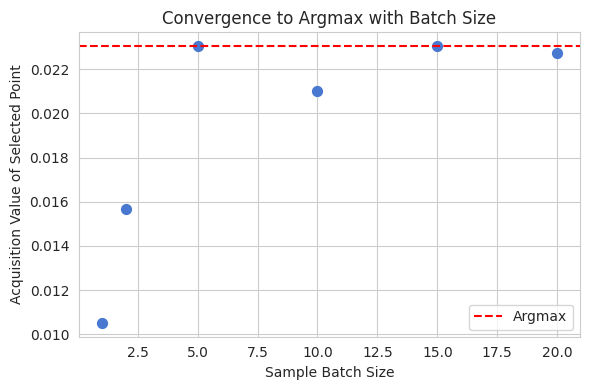

In [21]:
train_X, train_y, f = init_problem(seed = 0)

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = EIAcquisition(model_argmax, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True, sample_batch_size=1)
bo_sample_1 = BOLoop(model_sample, acq_sample, f)
bo_sample_1.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True, sample_batch_size=2)
bo_sample_2 = BOLoop(model_sample, acq_sample, f)
bo_sample_2.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True, sample_batch_size=5)
bo_sample_5 = BOLoop(model_sample, acq_sample, f)
bo_sample_5.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True, sample_batch_size=10)
bo_sample_10 = BOLoop(model_sample, acq_sample, f)
bo_sample_10.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True, sample_batch_size=15)
bo_sample_15 = BOLoop(model_sample, acq_sample, f)
bo_sample_15.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = EIAcquisition(model_sample, sample=True, sample_batch_size=20)
bo_sample_20 = BOLoop(model_sample, acq_sample, f)
bo_sample_20.run(n_iters=n_iters)

acq_vals_argmax = bo_argmax.history['acq_vals']
acq_vals_1 = bo_sample_1.history['acq_vals']
acq_vals_2 = bo_sample_2.history['acq_vals']
acq_vals_5 = bo_sample_5.history['acq_vals']
acq_vals_10 = bo_sample_10.history['acq_vals']
acq_vals_15 = bo_sample_15.history['acq_vals']
acq_vals_20 = bo_sample_20.history['acq_vals']

# Extract just the first iteration
first_acq_argmax = acq_vals_argmax[0].item()
first_acqs = [
    acq_vals_1[0].item(),
    acq_vals_2[0].item(),
    acq_vals_5[0].item(),
    acq_vals_10[0].item(),
    acq_vals_15[0].item(),
    acq_vals_20[0].item(),
]
batch_sizes = [1, 2, 5, 10, 15, 20]

# Plot convergence to argmax
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(batch_sizes, first_acqs, s=50)
ax.axhline(first_acq_argmax, color='red', linestyle='--', label='Argmax')
ax.set_xlabel('Sample Batch Size')
ax.set_ylabel('Acquisition Value of Selected Point')
ax.set_title('Convergence to Argmax with Batch Size')
ax.legend()
plt.tight_layout()

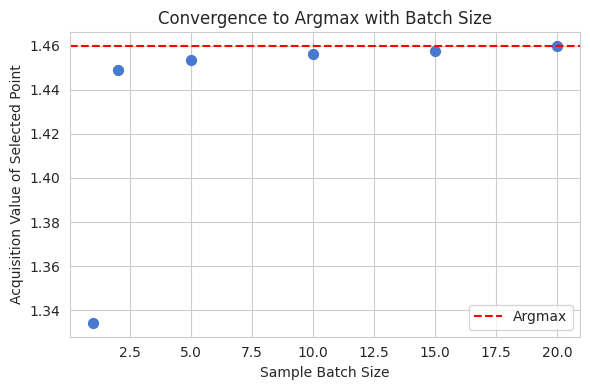

In [22]:
train_X, train_y, f = init_problem(seed = 0)

acq_func = UCBAcquisition
beta = 0.1

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = acq_func(model_argmax, beta=beta, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=1)
bo_sample_1 = BOLoop(model_sample, acq_sample, f)
bo_sample_1.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=2)
bo_sample_2 = BOLoop(model_sample, acq_sample, f)
bo_sample_2.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=5)
bo_sample_5 = BOLoop(model_sample, acq_sample, f)
bo_sample_5.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=10)
bo_sample_10 = BOLoop(model_sample, acq_sample, f)
bo_sample_10.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=15)
bo_sample_15 = BOLoop(model_sample, acq_sample, f)
bo_sample_15.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=20)
bo_sample_20 = BOLoop(model_sample, acq_sample, f)
bo_sample_20.run(n_iters=n_iters)

acq_vals_argmax = bo_argmax.history['acq_vals']
acq_vals_1 = bo_sample_1.history['acq_vals']
acq_vals_2 = bo_sample_2.history['acq_vals']
acq_vals_5 = bo_sample_5.history['acq_vals']
acq_vals_10 = bo_sample_10.history['acq_vals']
acq_vals_15 = bo_sample_15.history['acq_vals']
acq_vals_20 = bo_sample_20.history['acq_vals']

# Extract just the first iteration
first_acq_argmax = acq_vals_argmax[0].item()
first_acqs = [
    acq_vals_1[0].item(),
    acq_vals_2[0].item(),
    acq_vals_5[0].item(),
    acq_vals_10[0].item(),
    acq_vals_15[0].item(),
    acq_vals_20[0].item(),
]
batch_sizes = [1, 2, 5, 10, 15, 20]

# Plot convergence to argmax
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(batch_sizes, first_acqs, s=50)
ax.axhline(first_acq_argmax, color='red', linestyle='--', label='Argmax')
ax.set_xlabel('Sample Batch Size')
ax.set_ylabel('Acquisition Value of Selected Point')
ax.set_title('Convergence to Argmax with Batch Size')
ax.legend()
plt.tight_layout()

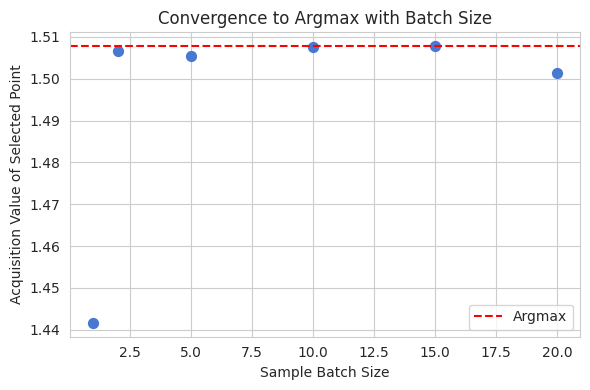

In [23]:
train_X, train_y, f = init_problem(seed = 0)

acq_func = UCBAcquisition
beta = 1.0

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = acq_func(model_argmax, beta=beta, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=1)
bo_sample_1 = BOLoop(model_sample, acq_sample, f)
bo_sample_1.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=2)
bo_sample_2 = BOLoop(model_sample, acq_sample, f)
bo_sample_2.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=5)
bo_sample_5 = BOLoop(model_sample, acq_sample, f)
bo_sample_5.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=10)
bo_sample_10 = BOLoop(model_sample, acq_sample, f)
bo_sample_10.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=15)
bo_sample_15 = BOLoop(model_sample, acq_sample, f)
bo_sample_15.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=20)
bo_sample_20 = BOLoop(model_sample, acq_sample, f)
bo_sample_20.run(n_iters=n_iters)

acq_vals_argmax = bo_argmax.history['acq_vals']
acq_vals_1 = bo_sample_1.history['acq_vals']
acq_vals_2 = bo_sample_2.history['acq_vals']
acq_vals_5 = bo_sample_5.history['acq_vals']
acq_vals_10 = bo_sample_10.history['acq_vals']
acq_vals_15 = bo_sample_15.history['acq_vals']
acq_vals_20 = bo_sample_20.history['acq_vals']

# Extract just the first iteration
first_acq_argmax = acq_vals_argmax[0].item()
first_acqs = [
    acq_vals_1[0].item(),
    acq_vals_2[0].item(),
    acq_vals_5[0].item(),
    acq_vals_10[0].item(),
    acq_vals_15[0].item(),
    acq_vals_20[0].item(),
]
batch_sizes = [1, 2, 5, 10, 15, 20]

# Plot convergence to argmax
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(batch_sizes, first_acqs, s=50)
ax.axhline(first_acq_argmax, color='red', linestyle='--', label='Argmax')
ax.set_xlabel('Sample Batch Size')
ax.set_ylabel('Acquisition Value of Selected Point')
ax.set_title('Convergence to Argmax with Batch Size')
ax.legend()
plt.tight_layout()

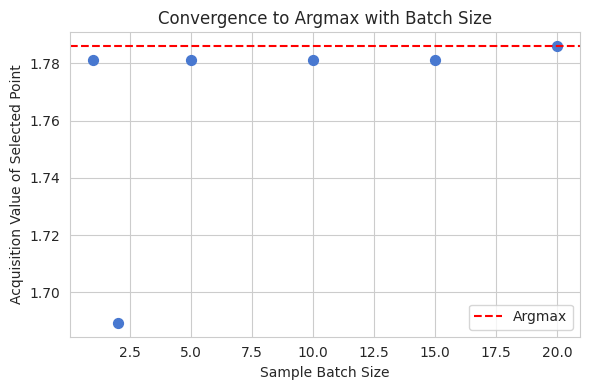

In [24]:
train_X, train_y, f = init_problem(seed = 0)

acq_func = UCBAcquisition
beta = 10.0

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = acq_func(model_argmax, beta=beta, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=1)
bo_sample_1 = BOLoop(model_sample, acq_sample, f)
bo_sample_1.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=2)
bo_sample_2 = BOLoop(model_sample, acq_sample, f)
bo_sample_2.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=5)
bo_sample_5 = BOLoop(model_sample, acq_sample, f)
bo_sample_5.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=10)
bo_sample_10 = BOLoop(model_sample, acq_sample, f)
bo_sample_10.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=15)
bo_sample_15 = BOLoop(model_sample, acq_sample, f)
bo_sample_15.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, beta=beta, sample=True, sample_batch_size=20)
bo_sample_20 = BOLoop(model_sample, acq_sample, f)
bo_sample_20.run(n_iters=n_iters)

acq_vals_argmax = bo_argmax.history['acq_vals']
acq_vals_1 = bo_sample_1.history['acq_vals']
acq_vals_2 = bo_sample_2.history['acq_vals']
acq_vals_5 = bo_sample_5.history['acq_vals']
acq_vals_10 = bo_sample_10.history['acq_vals']
acq_vals_15 = bo_sample_15.history['acq_vals']
acq_vals_20 = bo_sample_20.history['acq_vals']

# Extract just the first iteration
first_acq_argmax = acq_vals_argmax[0].item()
first_acqs = [
    acq_vals_1[0].item(),
    acq_vals_2[0].item(),
    acq_vals_5[0].item(),
    acq_vals_10[0].item(),
    acq_vals_15[0].item(),
    acq_vals_20[0].item(),
]
batch_sizes = [1, 2, 5, 10, 15, 20]

# Plot convergence to argmax
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(batch_sizes, first_acqs, s=50)
ax.axhline(first_acq_argmax, color='red', linestyle='--', label='Argmax')
ax.set_xlabel('Sample Batch Size')
ax.set_ylabel('Acquisition Value of Selected Point')
ax.set_title('Convergence to Argmax with Batch Size')
ax.legend()
plt.tight_layout()

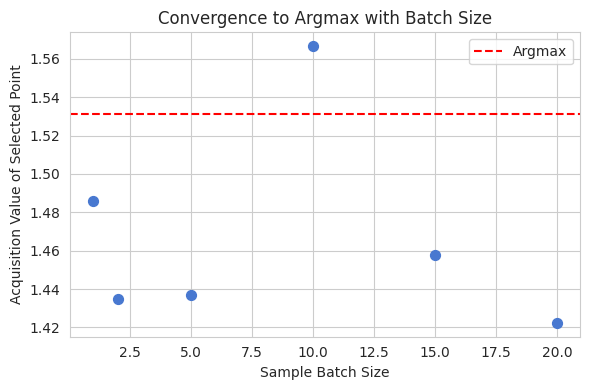

In [25]:
train_X, train_y, f = init_problem(seed = 0)

acq_func = TSAcquisition

# Argmax
model_argmax = GPModel(train_X, train_y)
acq_argmax = acq_func(model_argmax, sample=False)
bo_argmax = BOLoop(model_argmax, acq_argmax, f)
bo_argmax.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, sample=True, sample_batch_size=1)
bo_sample_1 = BOLoop(model_sample, acq_sample, f)
bo_sample_1.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, sample=True, sample_batch_size=2)
bo_sample_2 = BOLoop(model_sample, acq_sample, f)
bo_sample_2.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, sample=True, sample_batch_size=5)
bo_sample_5 = BOLoop(model_sample, acq_sample, f)
bo_sample_5.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, sample=True, sample_batch_size=10)
bo_sample_10 = BOLoop(model_sample, acq_sample, f)
bo_sample_10.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, sample=True, sample_batch_size=15)
bo_sample_15 = BOLoop(model_sample, acq_sample, f)
bo_sample_15.run(n_iters=n_iters)

model_sample = GPModel(train_X, train_y)
acq_sample = acq_func(model_sample, sample=True, sample_batch_size=20)
bo_sample_20 = BOLoop(model_sample, acq_sample, f)
bo_sample_20.run(n_iters=n_iters)

acq_vals_argmax = bo_argmax.history['acq_vals']
acq_vals_1 = bo_sample_1.history['acq_vals']
acq_vals_2 = bo_sample_2.history['acq_vals']
acq_vals_5 = bo_sample_5.history['acq_vals']
acq_vals_10 = bo_sample_10.history['acq_vals']
acq_vals_15 = bo_sample_15.history['acq_vals']
acq_vals_20 = bo_sample_20.history['acq_vals']

# Extract just the first iteration
first_acq_argmax = acq_vals_argmax[0].item()
first_acqs = [
    acq_vals_1[0].item(),
    acq_vals_2[0].item(),
    acq_vals_5[0].item(),
    acq_vals_10[0].item(),
    acq_vals_15[0].item(),
    acq_vals_20[0].item(),
]
batch_sizes = [1, 2, 5, 10, 15, 20]

# Plot convergence to argmax
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(batch_sizes, first_acqs, s=50)
ax.axhline(first_acq_argmax, color='red', linestyle='--', label='Argmax')
ax.set_xlabel('Sample Batch Size')
ax.set_ylabel('Acquisition Value of Selected Point')
ax.set_title('Convergence to Argmax with Batch Size')
ax.legend()
plt.tight_layout()